<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-1">Data Processing</a></span><ul class="toc-item"><li><span><a href="#Quotebank-Data" data-toc-modified-id="Quotebank-Data-1.1">Quotebank Data</a></span><ul class="toc-item"><li><span><a href="#Extracting-the-keyword-list" data-toc-modified-id="Extracting-the-keyword-list-1.1.1">Extracting the keyword list</a></span></li><li><span><a href="#Extracting-quotes-of-interest" data-toc-modified-id="Extracting-quotes-of-interest-1.1.2">Extracting quotes of interest</a></span></li></ul></li><li><span><a href="#Speakers-Data" data-toc-modified-id="Speakers-Data-1.2">Speakers Data</a></span><ul class="toc-item"><li><span><a href="#Extracting-labels-QIDs" data-toc-modified-id="Extracting-labels-QIDs-1.2.1">Extracting labels QIDs</a></span></li><li><span><a href="#Extracting-labels-climate" data-toc-modified-id="Extracting-labels-climate-1.2.2">Extracting labels climat</a></span></li><li><span><a href="#Speakers-Filtering" data-toc-modified-id="Speakers-Filtering-1-2.3">Speakers Filtering</a></span></li><li><span><a href="#One-Hot-Encoding" data-toc-modified-id="One-Hot-Encoding-1-2.4">One Hot Encoding</a></span></li></ul></li></ul></li><li><span><a
href="#Visualisation" data-toc-modified-id="Visualisation-1.3">Visualisation</a></span><ul class="toc-item"><li><span><a href="#Quotation-Distribution" data-toc-modified-id="Quotation-Distribution-1.3">Quotation Distribution</a></span><ul class="toc-item"><li><span><a href="#Per-month" data-toc-modified-id="Per-month-1.3.1">Per month</a></span></li><li><span><a href="#Per-Year" data-toc-modified-id="Per-Year-1.3.2">Per-Year</a></span></li></ul></li><li><span><a href="#Speakers-Distribution" data-toc-modified-id="Speakers-Distribution-1.4">Speakers Distribution</a></span><ul class="toc-item"><li><span><a href="#Mixed-Speakers" data-toc-modified-id="Mixed-Speakers-1.4.1">Mixed Speakers</a></span></li><li><span><a href="#Climate-Speakers" data-toc-modified-id="Climate-Speakers-1.4.2">Climate-Speakers</a></span></li><li><span><a  href="#TOP-10-Climate-Speakers" data-toc-modified-id="TOP-10-Climate-Speakers-1.4.3">TOP 10 Climate Speakers</a></span></li></ul></li></ul></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-1.5">Sentiment Analysis</a></span><ul class="toc-item"><li><span><a href="#Positive-and-negative-distributions-through-the-years" data-toc-modified-id="Positive-and-negative-distributions-through-the-years-1.5.1">Positive and negative distributions through the years</a></span></li><li><span><a href="#Democratic-vs-Republican" data-toc-modified-id="Democratic-vs-Republican-1.5.2">Democratic vs Republican</a></span></li></ul></li><li><span><a href="#Classification-of-Speakers" data-toc-modified-id="Classification-of-Speakers-1.6">Classification of Speakers</a></span><ul class="toc-item"><li><span><a href="#Data-preparing" data-toc-modified-id="Data-Preparing-1.6.1">Data Preparing</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-1.6.2">Baseline Model</a></span></li><li><span><a href="#Modification-of-the-train-set" data-toc-modified-id="Modification-of-the-train-set-1.6.3">Modification of the train set</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1.6.4">Logistic Regression</a></span></li></ul></li></ul></div>

In [2]:
import numpy as np
import pandas as pd
import json

#plot library
import seaborn as sns
import matplotlib.pyplot as plt


#ast import
import ast
from ast import literal_eval


#image library
from wordcloud import WordCloud
from PIL import Image

#datetime
from datetime import datetime


#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models


#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle 


#NLP libraries
import spacy, nltk, gensim, sklearn


#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle



#imblearn imports
from imblearn.under_sampling import RandomUnderSampler

# Data Processing

## Quotebank Data

First, let's recover the quotations of interest : as our project is based on the caracterisation of speakers, we decided to pre-select  quotations relating to a peaker (i.e speaker value is different from 'None'). 
Moreover, we selected quotations whose subject is linked to climate change : to do so we recovered a list of keyword by analyzing with NLP the 2 dataset train_1.tcsv and Wiki_train.tcsv. These 2 datas contains quotations and a label : 0 if they are not talking and in the other case 1. Then, we selected quotes that contains at least one of these words(cf chunk_filtering method).

### Extracting the keyword list

In [4]:
#Load the data 
data1 = pd.read_csv('data/Wiki_train.tsv', sep='\t')
data2=pd.read_csv('data/train_1.tsv', sep='\t')

In [5]:
#select columns of interest
data1.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)  
data2.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)

We decided to use 2 different data and merge them to have quotes from different sources in order to diversify our list of words.

In [6]:
#merge the data together 
subdata = pd.concat([data1, data2])

> ##### Creation of our bag of word 

In [ ]:
As we used a simple

In [7]:
#Convert the collection of text documents to a matrix of token counts.
#remove stop_word, and select n_gram of maximum size (1,2), lowercase = False bcause we ay recover some name's organisation. 
vectorizer = CountVectorizer(stop_words = 'english',ngram_range=(1, 2),lowercase=False)


#create bag of words features
X = vectorizer.fit_transform(subdata.sentence)


print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int climate
Y = np.array(subdata.label)

print(Y.shape)
print(X.shape)

#shuffle the data

X, Y = shuffle(X, Y, random_state=0)

#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 6000
Number of features: 75261
(6000,)
(6000, 75261)


TF-IDF is a popular approach used to weigh terms for NLP tasks because it assigns a value to a term according to its importance in a document scaled by its importance across all documents in your corpus. Let's transform our bag-of-word with tf-idf and see if we get better result with it.

In [8]:
tfidf_transformer = TfidfTransformer()

#transform the count matrix X_train and X_test to a normalized tf-idf representation
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf=tfidf_transformer.fit_transform(X_test)


X_train_tfidf.shape 
X_test_tfidf.shape

(1200, 75261)

In [9]:
train = [X_train, X_train_tfidf]
test = [X_test, X_test_tfidf]

> Train a supervised classifier based on the labeled docs

We will train logistic regression for the classification task and find the keyword related to climate. As we see previoulsy we get more feature than documents, so we need to regularized our method : we will try l2 regularization for basic logistic regression. 
We will use cross validation to hypertun our parameter and as logistic regression by default uses Gradient Descent, we will compare it to SGD Classifier which use which gradient descent making it faster. 

In [10]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000] 


param_grid = dict(C=C) 

logistic = LogisticRegression(solver = 'lbfgs', penalty = 'l2') 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9394273127753303
Best Params:  {'C': 0.1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9443832599118943
Best Params:  {'C': 10}


> C = 10, and tf-idf train data gives us the best score.

In [11]:
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log', 'hinge']
max_iter=[1000, 10000, 100000, 1e6]
n_jobs = [-1]


param_grid = dict(penalty=penalty, 
alpha=alpha,loss=loss,max_iter=max_iter, n_jobs=n_jobs) 

logistic = SGDClassifier() 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9315147407658422
Best Params:  {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 1000000.0, 'n_jobs': -1, 'penalty': 'l2'}
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9420027109454422
Best Params:  {'alpha': 0.0001, 'loss': 'log', 'max_iter': 100000, 'n_jobs': -1, 'penalty': 'l2'}


> SDG with logistic regression (loss = 'log'), and tf-idf train data give us approximatly the same score as for basic logitic regression. Let's use both and see which keyword we prefere. 

In [12]:
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 10, penalty='l2').fit(X_train_tfidf, Y_train)
predicted = clf.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.9508333333333333


In [13]:
coefs=clf.coef_[0] #recover coeffiction from the training
top_three = np.argpartition(coefs, -30)[-30:] # rearrange coefficient, and select the 30th first one
print(np.array(vectorizer.get_feature_names_out())[top_three])

['gases' 'fuels' 'diesel' 'greenhouse gases' 'levels' 'increase' 'gas'
 'warmer' 'carbon tax' '2010' 'climate change' 'precipitation' 'emission'
 'change' 'glaciers' 'policy' 'GHG' 'global warming' 'global' 'greenhouse'
 'cap' 'temperatures' 'Glacier' 'warming' 'increased' 'fuel' 'carbon'
 'climate' 'Climate' 'emissions']


In [14]:
clf_sdg = SGDClassifier(loss="log", penalty="l2", alpha = 0.0001,   max_iter=1e6, n_jobs=-1).fit(X_train_tfidf, Y_train)
predicted = clf_sdg.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.95


In [15]:
coefs_sdg=clf_sdg.coef_[0]
top_three_sdg = np.argpartition(coefs_sdg, -30)[-30:]

print(np.array(vectorizer.get_feature_names_out())[top_three_sdg])

['energy' 'gases' 'change' 'precipitation' 'greenhouse gases' '2010' 'CO'
 'temperature' 'cap' 'Glacier' 'increased' 'gas' 'policy' 'global'
 'temperatures' 'carbon' 'levels' 'Climate' 'warmer' 'warming' 'fuels'
 'GHG' 'diesel' 'emissions' 'greenhouse' 'emission' 'climate'
 'global warming' 'glaciers' 'fuel']


> Both list seems resonable, let's use the one from basic logistic regression.

In [23]:
keywords = np.array(vectorizer.get_feature_names_out())[top_three]
keywords=np.delete(keywords, [4, 5, 9,13,  15, 18, 20, 21,  24]) #remove unwanted words that can induce confusion

In [24]:
#let's see our final list
keywords

array(['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'glaciers', 'GHG', 'global warming', 'greenhouse', 'Glacier',
       'warming', 'fuel', 'carbon', 'climate', 'Climate', 'emissions'],
      dtype=object)

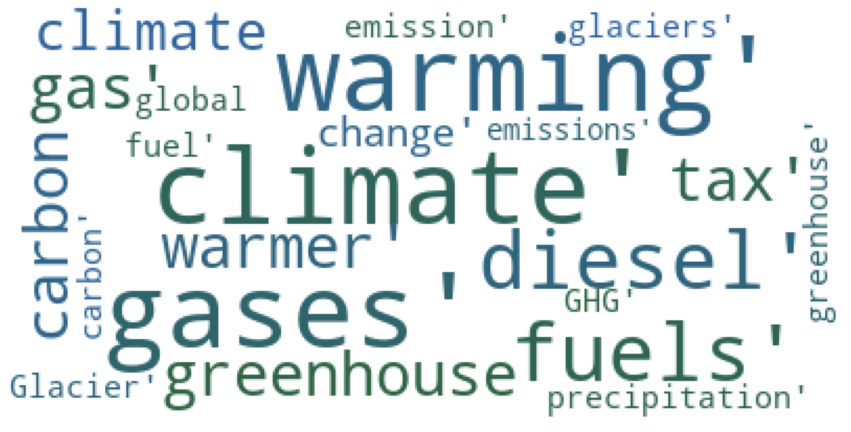

In [81]:
wordcloud = WordCloud(max_font_size=50, contour_width=3, background_color='white' ).generate(str(keywords))

# Display the generated image:

def couleur(*args, **kwargs):
    import random
    return "rgb(47, 100, {})".format(random.randint(60, 170))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud.recolor(color_func = couleur))
plt.axis("off")
plt.show();

fig.savefig('image/key_word-wordcloud.png')

### Extracting quotes of interest

In [38]:
def chunk_filtering(chunk, lst):
    template=[] #Creation of an empty list :it's always cheaper to append to a list and create a DataFrame than append on a empty dataframe.
    for i in lst: 
        template.append(chunk.loc[(chunk["quotation"].apply(lambda x : i in str(x).split(' ')) )& 
                                  (chunk["speaker"].apply(lambda x: x!= "None"))&
                                  (chunk["qids"].apply(lambda x: len(np.array(x))==1))].drop(['phase', 'urls', 'probas'], axis=1))
        #Select quotations with value in speaker column different from 'None' and 
        #quotations containing the key word and drop phase, urls and probas  column. 
        #As the speaker is identified by their name and not their QID, we select the ones that have a unique QID to facilitate our analysis.
        
    return (pd.concat(template, ignore_index=True))# return a dataframe with our data of interest

In [39]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_json(f'data/quotes-{date}.json.bz2', lines=True, compression='bz2', chunksize=100000)

In [40]:
keywords = ['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'glaciers', 'GHG', 'global warming', 'greenhouse', 
       'Glacier', 'warming', 'fuel', 'carbon', 'climate', 'Climate',
       'emissions']


for date, df in dico.items() : 
    for i, chunk in enumerate(df) : 
        chunk_clean=chunk_filtering(chunk, keywords) #recover interested row of the chunk
        header = i == 0 #we kept the name of the column only for the first chunk
        mode = 'w' if i == 0 else 'a' # For appending data to an existing CSV file (so for every chunk exepct the first one), 
                                        #we can use mode = a
        chunk_clean.to_csv(path_or_buf=f"data/clean_quotes-{date}.bz2",compression='bz2',header=header, mode=mode, index = False ) #Load to CSV.    
        

In [5]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    clean = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    clean.drop_duplicates(subset=['quotation'], inplace= True) #make sure there's no duplicate
    dico_clean[date]=clean #add to the dico
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

In [6]:
print(" At result, we extracted {} quotes fromes quotebank data".format(length))

 At result, we extracted 292820 quotes fromes quotebank data


## Speakers Data

### Extracting labels QIDs

The provided speaker_attributes.parquet file contains attributes in terms of QIDs, thereby being uninterpretable by humans (df_qid).
To map the QIDs to meaningful labels, we used the provided wikidata_labels_descriptions_quotebank.csv.bz2 containing the label and value for the respective QID containing the df_qid (df_label_qid).
By combining the information of both we can obtained usefull information about speakers.

> ####  *Load parquet file*

In [7]:
#Loading our speakers attribute dataset, and the dataset necessary to interpret our QIDs.
df_qid = pd.read_parquet("speaker_attributes.parquet",engine= "pyarrow" )
df_label_qid = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2',index_col='QID')

> #### *Somes visualisation and sort of the parquet file*

In [8]:
df_qid.id.is_unique

True

In [9]:
df_qid.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


Let's verify that academic_degree has revelant values.

In [10]:
print("There's no academic degree revelant value ? {}".format(all(df_qid.academic_degree.isna())))

There's no academic degree revelant value ? False


It seems that academic degree values are revelant, we decided to drop lastrevid, US_congress_bio_ID, type, Alisiase as they will not be used in our project.

In [11]:
df_qid.drop(['lastrevid', 'US_congress_bio_ID', 'type', 'aliases'], axis=1, inplace=True)

> #### *Transformation of the df_qid with the label value from df_label_qid*

In [12]:
#We found that one of the QID was deleted from Wikidata. We will start by dropping this value, so that it does not distrurb our labelling. 

def transform(y):
    if y is None: return None
    x = set(y)
    x.discard("Q99753484")
    return np.array(list(x))
    
df_qid['occupation']=df_qid['occupation'].apply(lambda y : transform(y))

In [13]:
#We found out that some of the QIDs used in the speaker attribute file are actually redirection from an original QID. 
#We will manulally add their corresponding information using the orginal QID. We found the corespondance manualy between the two. 
#Here, there are in order, respectively the redirection QID, and its corresponding original one. One of he QID was only present 
#as a redirection, so we manually added this one (Q3186984), and its corresponding info. 

redirect_QID=['Q3268166', 'Q11815360', 'Q12014399', 'Q16287483',
              'Q20432251', 'Q21550646', 'Q13365117', 'Q13424794',
             'Q1248362', 'Q6859927', 'Q15145782',
             'Q15991263', 'Q12455619', 'Q5568256', 
             'Q6363085', 'Q11819457', 'Q12334852', 'Q15145783']
actual_QID=['Q1113899', 'Q1919436', 'Q250867', 'Q6051619',
             'Q26934816', 'Q18431816', 'Q12840545', 'Q5157338',
            'Q3455803', 'Q715222', 'Q1052281',
            'Q2743689', 'Q7019111', 'Q3738699', 
            'Q380075', 'Q3391743', 'Q476246', 'Q2449503']


lst=[['Journalist', 'monthly magazine of the United Kingdom‘s National Union of Journalists (NUJ)']]
indexes=['Q3186984']
col=['Label', 'Description']
for i in range(len(redirect_QID)):
    lst.append([df_label_qid.loc[actual_QID[i]]['Label'], 
                df_label_qid.loc[actual_QID[i]]['Description']])
    indexes.append(redirect_QID[i])

additional_df= pd.DataFrame(lst, columns= col, index=indexes)
df_label=df_label_qid.append(additional_df, ignore_index= False)

In [14]:
#Applying the function to every column containing QIDs. 
cols=['nationality', 'gender', 'ethnic_group','occupation', 'party', 'academic_degree', 'candidacy', 'religion'] #List of columns 
#containing QID to be replace

df_qid[cols] = df_qid[cols].applymap(lambda d: d if d is not None else []) #Replacing every None value with an empty list for futur analysis.
df_qid[cols] = df_qid[cols].applymap(lambda y: [df_label.loc[Q].Label for Q in y]) #Replacing QIDs with their corresponding label.

### Extracting labels climate

Now, we want to see which speakers said quotes that we consider as climate-related and climate change sceptical. We will match speaker from the df_qid with a value septic/climate. We will add two boolean columns to our dataframe df_qid: one for climate-related, and one for climate change sceptical. In order to do that, we will select every QID that appears in our list of climate-related-quotes and climat-change-sceptical quotes

> #### *Qid_climate list*

In [15]:
qid_climate=[]

#iteration in the dico_clean containing extracted files for climate involved quotes
for key, file in dico_clean.items() :
    qid_climate.append(file.drop_duplicates(['qids'], keep='first')['qids'].map(lambda y : ast.literal_eval(y)[0]).tolist()) #add unique QIDs from each file
qid_climate=set(item for sublist in qid_climate for item in sublist)#create a set with unique QIDs from each year/file.

In [16]:
print("We extracted {} QIDs related to speakers that talk about climate.".format(len(qid_climate)))

We extracted 63645 QIDs related to speakers that talk about climate.


> #### *Add an additional column to df_qid*

In [17]:
df_qid['climate']=0 #create a column named climate with value equals 0
df_qid.loc[df_qid[pd.Index(df_qid.id.isin(pd.Index(qid_climate)))].index, 'climate']=1 #replace with 1 for speakers that appear in the climate-involved quotes.

In [18]:
df_qid.sample(10)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
3322191,None,[],[],[],[],[],[],Q102111104,Davoud Cheraghi,[],[],0
2832288,None,[],[],[],"[researcher, biologist]",[],[],Q57064968,Tuan Leng Tay,[],[],0
5804040,[+1948-02-17T00:00:00Z],[United Kingdom],[male],[],[association football player],[],[],Q5336430,Eddie Rampling,[],[],0
6258228,None,[],[],[],[researcher],[],[],Q60163747,Roberto Russo,[],[],0
5328373,None,[],[],[],[researcher],[],[],Q86268278,Stephen D Ayers,[],[],0
257886,[+1889-00-00T00:00:00Z],[],[male],[],[poet],[],[],Q12214960,Sābā Qayṣar Zurayq,[],[],0
8236457,[+1923-01-13T00:00:00Z],[Soviet Union],[male],[],"[aircraft pilot, military officer]",[Communist Party of the Soviet Union],[],Q16681028,Pyotr Mikhaylovich Nikonorov,[],[],0
2562802,None,[],[male],[],[],[],[],Q16173169,None,[],[],0
2801832,[+1716-01-01T00:00:00Z],[],[male],[],[],[],[],Q55122640,Friedrich Theodosius Müller,[],[],0
7193090,[+1956-01-01T00:00:00Z],[Spain],[male],[],[politician],[],[],Q25508854,Antonio Negreira Noya,[],[],0


### Speakers Filtering

As a good data scientist, the first thing to do is to clean up the data. In order to do that, we will first check for missing rows. Then we will replace the date of birth by the year of birth. Lastly, we will filter our speakers in order to keep only the ones whose age is bewteen 12 and 100 . (As climate change is a relatively new topic, and we do not consider quotes from speakers that are younger then 12 years old).

In [19]:
speakers=df_qid.copy()

In [20]:
speakers.sample(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
0,[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],[],"[slaveholder, cartographer, statesperson, mili...",[independent politician],[],Q23,George Washington,"[1792 United States presidential election, 178...",[Episcopal Church],0
1,[+1952-03-11T00:00:00Z],[United Kingdom],[male],[White British],"[novelist, comedian, screenwriter, children's ...",[],[],Q42,Douglas Adams,[],[],0
2,[+1868-08-23T00:00:00Z],[Belgium],[male],[],"[librarian, inventor, bibliographer, informati...",[],[],Q1868,Paul Otlet,[],[],0
3,[+1946-07-06T00:00:00Z],[United States of America],[male],[],"[autobiographer, painter, statesperson, politi...",[Republican Party],[],Q207,George W. Bush,"[2000 United States presidential election, 200...","[United Methodist Church, Episcopal Church, Me...",1
4,[+1599-06-06T00:00:00Z],[Spain],[male],[],[painter],[],[],Q297,Diego Velázquez,[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,None,[United States of America],[male],[],[politician],[],[],Q106406560,Barker B. Howard,[],[],0
9055977,None,[United States of America],[male],[],[politician],[],[],Q106406571,Charles H. Macomber,[],[],0
9055978,[+1848-04-01T00:00:00Z],[],[female],[],[],[],[],Q106406588,Dina David,[],[],0
9055979,[+1899-03-18T00:00:00Z],[],[female],[],[],[],[],Q106406593,Irma Dexinger,[],[],0


In [21]:
print("Is there some missing rows ? {} ".format(np.array([speakers.drop(columns=['label', 'id']).isnull().any(axis=1)]).all()))

Is there some missing rows ? False 


In [22]:
speakers.date_of_birth=speakers.fillna(0).date_of_birth.map(lambda y : str(y).split("-")[0][3:])#Keep only the year of birth.
speakers=speakers.loc[speakers['date_of_birth'].apply(lambda x: x!= '' and int(x)>1920 and int(x)< 2008)]#Keep only speakers born after 1920.
speakers['date_of_birth']=speakers['date_of_birth'].astype(int)

In [23]:
speakers.sample(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
8483849,1964,[Poland],[male],[],"[paleobiologist, geologist]",[],[],Q56491262,Jaroslaw Stolarski,[],[],0
1434353,1981,[Japan],[female],[],[swimmer],[],[],Q16221494,Yukiko Osada,[],[],0
7175359,1964,[United Kingdom],[male],[],[],[],[],Q22443343,Arun Nayar,[],[],0
2611202,1976,[Indonesia],[male],[],[],[],[],Q19725677,Ciliandra Fangiono,[],[],0
8066371,1982,[Italy],[male],[],[association football player],[],[],Q5241546,Davide Cattaneo,[],[],0


In [24]:
#function that removes the nan from the list of attributes 
def handle_nan(y) :
    try :
        return literal_eval(y)

    except Exception as e:
        y = y.replace("nan", "0")
        return literal_eval(y)

In [25]:
columns_eval = ['occupation','religion','nationality','ethnic_group','party','academic_degree', 'gender'] #our columns of interest

### One Hot Encoding

In [44]:
#functions to create categorical columns  
def one_hot(list, column):
    for o in list: #Iterating over the list of genres. 
        speakers[f'{o}'] = 0 #Creating a new onehot feature column for each genre, filling it with False.
        speakers.loc[speakers[column].apply(lambda value : o in value), f'{o}'] = 1 #For each album, putting True in the 
    #onehot column corresponding to its genre. 

In [45]:
for column in columns_eval : 
    subdata=speakers[column].explode().value_counts()
    one_hot(subdata.index.tolist()[0:20], column)

/var/folders/fv/mxk3vn_n5ms9wmw9s5_bxg1r0000gn/T/ipykernel_49641/2642540982.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  speakers[f'{o}'] = 0 #Creating a new onehot feature column for each genre, filling it with False.


In [46]:
speakers.sample(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,...,male organism,cisgender female,two-spirit,agender,cisgender male,neutral sex,bigender,transfeminine,transmasculine,female organism
5147496,[+1960-09-04T00:00:00Z],[Iceland],[female],[],[],[],[],Q61972336,Elín Stefánsdóttir Hirst,[],...,0,0,0,0,0,0,0,0,0,0
3316431,[+2001-07-06T00:00:00Z],[Norway],[female],[],[athletics competitor],[],[],Q101079188,Andrea Modin Engesæth,[],...,0,0,0,0,0,0,0,0,0,0
4322329,[+1932-03-04T00:00:00Z],[],[male],[],"[playwright, contributing editor, director, wr...",[],[],Q94835535,Fritz Schwarz,[],...,0,0,0,0,0,0,0,0,0,0


In [47]:
speakers.drop(['occupation', 'religion', 'nationality', 
               'ethnic_group', 'party', 'academic_degree', 'id', 'candidacy', 'gender'], axis=1).to_csv('data/one_hot.bz2', compression = 'bz2', index=False)

# Visualisation

## Quotation Distribution

In [26]:
tmp=[]
for years, quotes in dico_clean.items() : 
    tmp.append(quotes) #concatenate quotation from every year

quotes = pd.concat(tmp) #transfrom to Dataframe

In [27]:
quotes.date.map(lambda y : datetime.strptime(y, '%Y-%m-%d %H:%M:%S')) #transform date formate to datetime object
quotes.sort_values(by='date', inplace=True) #sort the date

In [66]:
quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences
55230,2019-10-27-006256,"Clean Cars For America Climate Initiative,",Charles Schumer,['Q380900'],2019,1
7206,2018-02-07-096361,"On the warmer days, it definitely helps morale...",Julian Hill,['Q27435059'],2018,4
75765,2019-09-28-033195,Now everyone is busy with climate change and I...,Danny Danon,['Q2919440'],2019,1


### Per month

In [29]:
quotes['date'] = pd.to_datetime(quotes['date']).dt.strftime('%Y-%m') #change the format of the year to Year-Month

<Figure size 1080x1080 with 0 Axes>

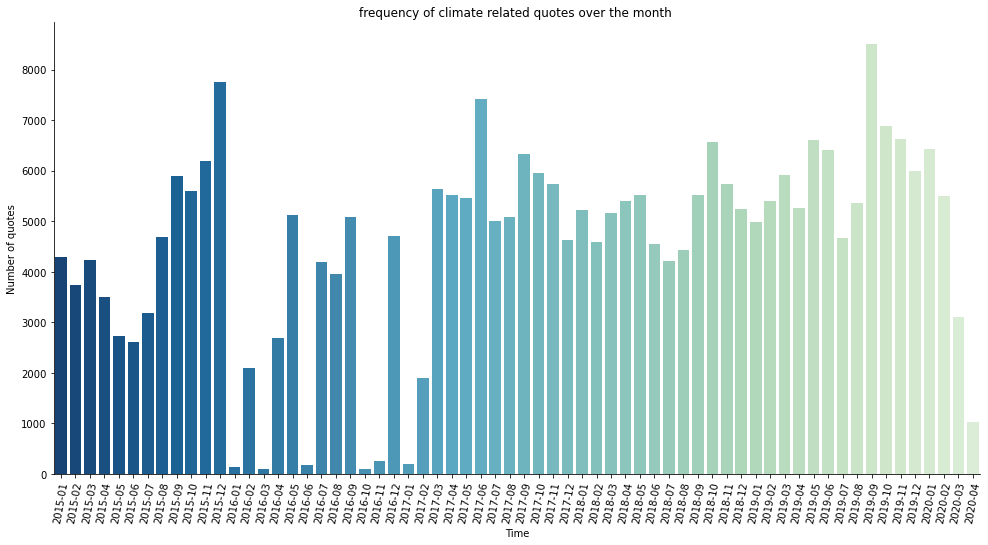

In [30]:
#initialize color palette
palette = sns.color_palette("GnBu", n_colors=76)
palette.reverse()


#plot the figure
fig = plt.figure(figsize=(15,15))
fig=sns.catplot(data=quotes, x = 'date',  kind="count", 
               palette=palette,height=7, aspect=2)


#plot parameters settings 
fig.set_xticklabels(rotation=80)
fig.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the month ') #We chose a log scale for better data visulalisation. 



sns.despine()
plt.show()

#save the figure
fig.savefig('image/temporal_per_month.png')

### Per Year

In [31]:
quotes['date'] = pd.to_datetime(quotes['date']).dt.strftime('%Y') #change the format of the year to Year

<Figure size 1080x1080 with 0 Axes>

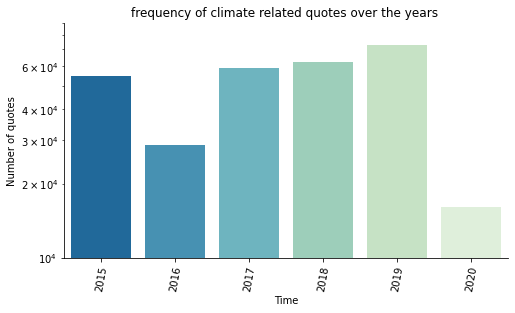

In [32]:
palette = sns.color_palette("GnBu", n_colors=6)
palette.reverse()

fig = plt.figure(figsize=(15,15))
fig=sns.catplot(data=quotes, x = 'date',  kind="count", 
               palette=palette,height=4, aspect=1.8)



fig.set_xticklabels(rotation=80)
plt.ylim(1e4, 9e4)

fig.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the years ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()
plt.show()
fig.savefig('image/temporal_per_year.png')

## Speakers Distribution

### Mixed Speakers

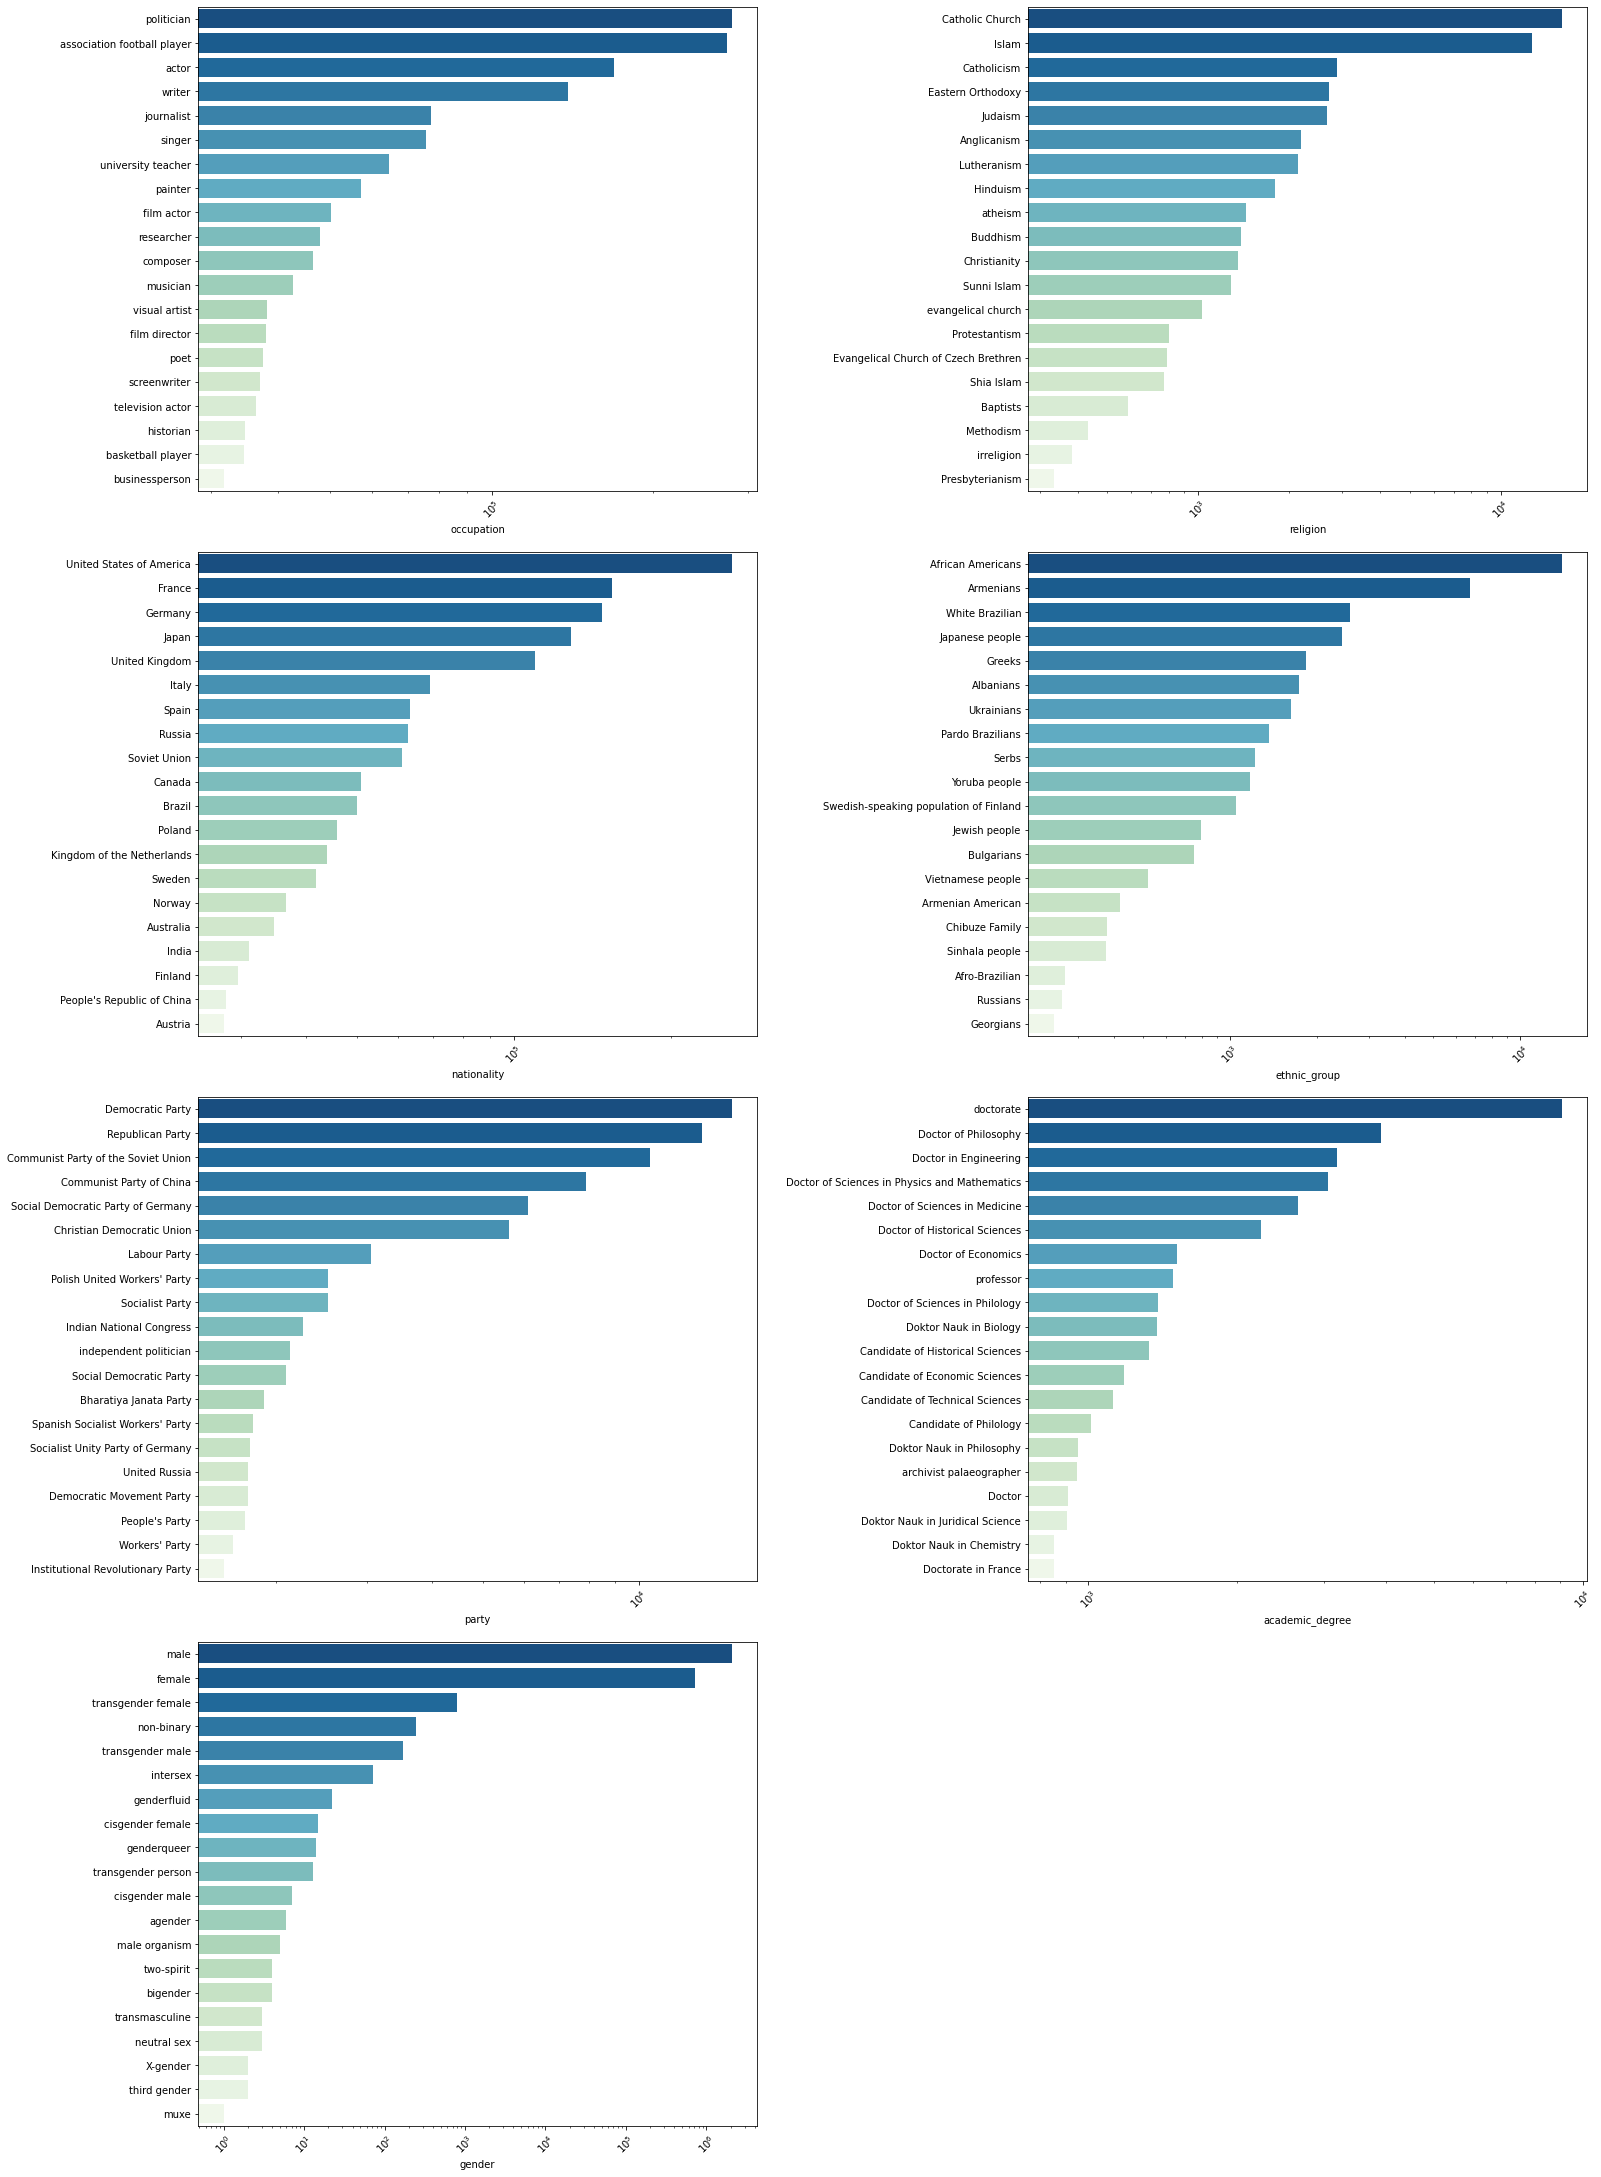

In [33]:
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]

fig, axs = plt.subplots(4,2, figsize=(20,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=1, w_pad = 24, h_pad = 4)

palette = sns.color_palette("GnBu", n_colors=20)
palette.reverse()


for idx, column in enumerate(columns_eval): 
    
    
    
    subdata=speakers[column].explode().value_counts()
    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]], palette =palette)
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')
    axs[index[idx][0]][index[idx][1]].figure.savefig(f'image/speakers_{column}.png')
    
    

plt.show()


### Climate Speakers

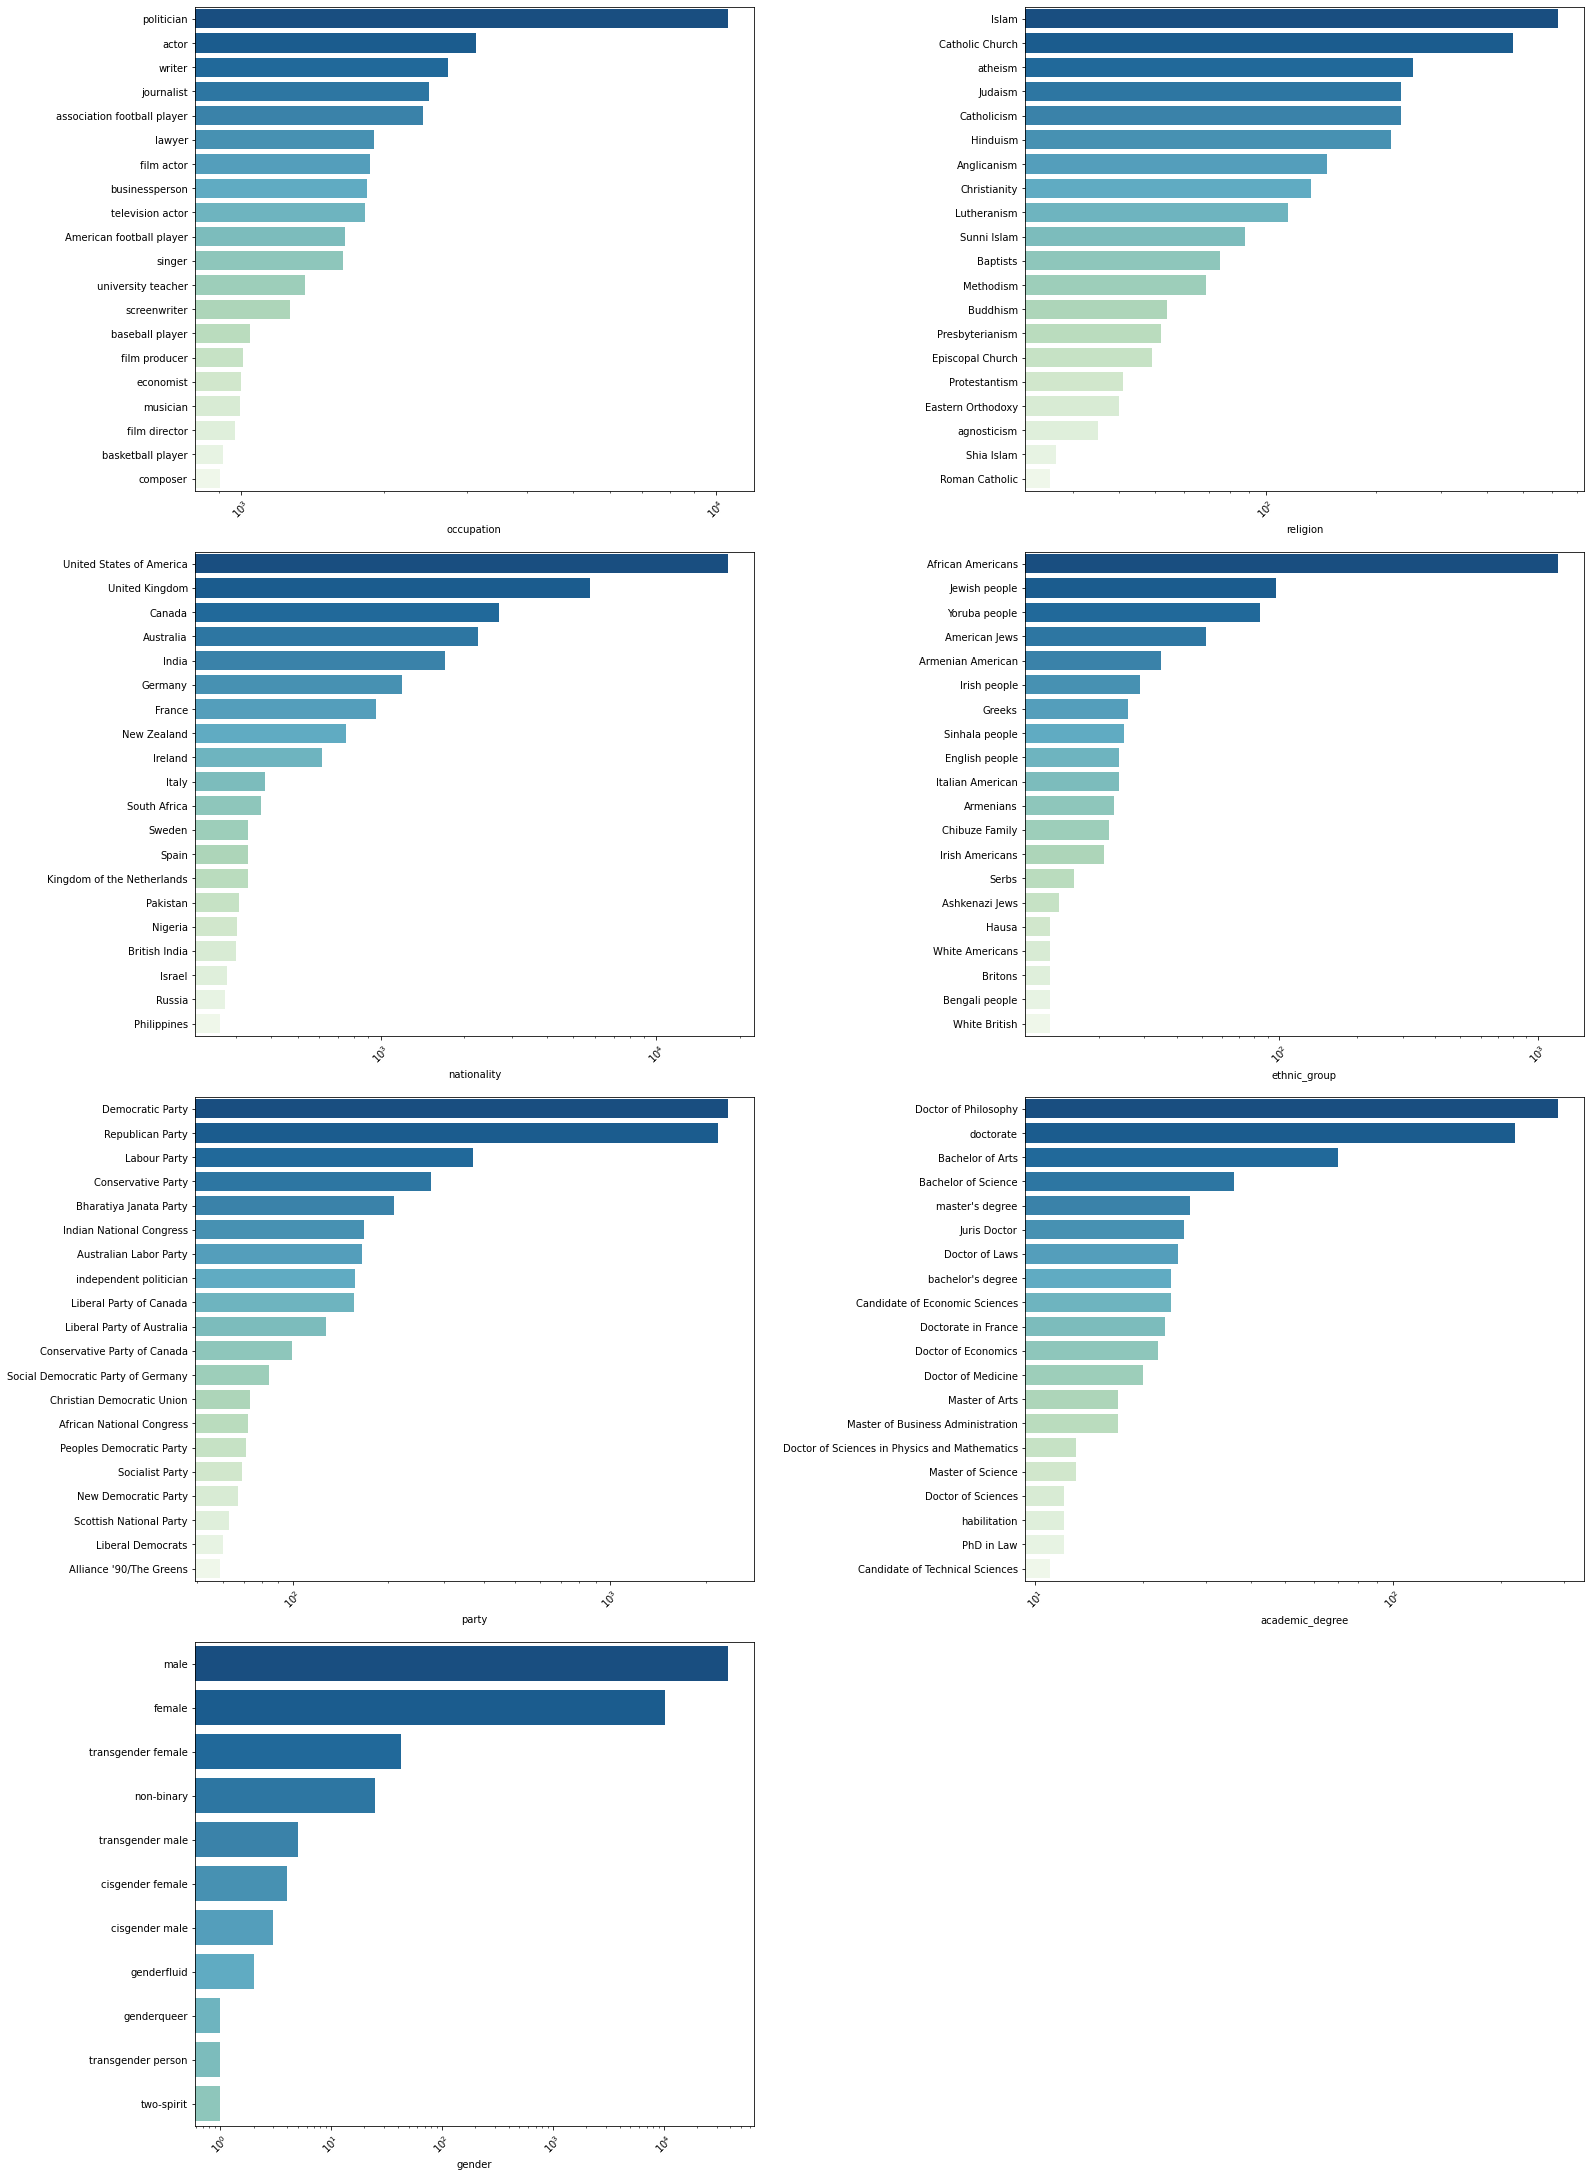

In [34]:
climate = speakers[speakers['climate']==1]
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]


fig, axs = plt.subplots(4,2, figsize=(20,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=1, w_pad = 24, h_pad = 4)


for idx, column in enumerate(columns_eval): 
    
    subdata=climate[column].explode().value_counts()
    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]], palette =palette)
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')
    axs[index[idx][0]][index[idx][1]].figure.savefig(f'image/speakers_climate_{column}.png')



### TOP 10 Climate Speakers

In [35]:
climate = climate.set_index('id')

In [36]:
for key,value in dico_clean.items(): 
    df = value.groupby('qids').sum()
    df.index= df.index.map(lambda x: literal_eval(x)[0])
    df = df.rename(columns={'numOccurrences': str(key)})
    climate=climate.join(df)

In [37]:
climate.head(2)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,climate,2020,2019,2018,2017,2016,2015
id,,,,,,,,,,,,,,,,,
Q207,1946,[United States of America],[male],[],"[autobiographer, painter, statesperson, politi...",[Republican Party],[],George W. Bush,"[2000 United States presidential election, 200...","[United Methodist Church, Episcopal Church, Me...",1,NaN,3.0,38.0,18.0,5.0,90.0
Q873,1949,[United States of America],[female],[],"[television actor, voice actor, television pro...",[Democratic Party],[],Meryl Streep,[],[atheism],1,NaN,2.0,3.0,NaN,NaN,2.0


In [38]:
climate = climate.fillna(0)
climate[['2020','2019','2018','2017','2016','2015']]=climate[['2020','2019','2018', '2017', '2016', '2015']].astype(int)

In [39]:
climate['Total']=climate[['2020','2019','2018','2017','2016','2015']].sum(axis=1)

In [40]:
climate.head(2)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,climate,2020,2019,2018,2017,2016,2015,Total
id,,,,,,,,,,,,,,,,,,
Q207,1946,[United States of America],[male],[],"[autobiographer, painter, statesperson, politi...",[Republican Party],[],George W. Bush,"[2000 United States presidential election, 200...","[United Methodist Church, Episcopal Church, Me...",1,0,3,38,18,5,90,154
Q873,1949,[United States of America],[female],[],"[television actor, voice actor, television pro...",[Democratic Party],[],Meryl Streep,[],[atheism],1,0,2,3,0,0,2,7


In [41]:
top_10 = {}
for year in ['2015', '2016', '2017', '2018', '2019', '2020'] :
    cols=['date_of_birth', 'nationality', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'label', 'candidacy', 'religion', year]
    top_10[year]=climate[cols].sort_values(by=[year], inplace=False, ascending=False).head(10)

In [42]:
top_10['2015']

,date_of_birth,nationality,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,2015
id,,,,,,,,,,
Q76,1961,[United States of America],"[African Americans, Multiracial American, Luo ...","[community organizer, statesperson, politician...",[Democratic Party],"[Bachelor of Arts, Juris Doctor]",Barack Obama,[2004 United States Senate election in Illinoi...,"[Protestantism, congregational church, Congreg...",15034
Q1253,1944,[South Korea],[Koreans],"[diplomat, politician]",[independent politician],[],Ban Ki-moon,[],"[Confucianism, Buddhism]",2966
Q4910865,1967,"[Australia, United Kingdom]",[],"[lawyer, trade unionist, politician]",[Australian Labor Party],[],Bill Shorten,[],[],2760
Q5605742,1965,[Australia],[],[politician],[Liberal Party of Australia],[],Greg Hunt,[],[],2633
Q450675,1936,"[Vatican City, Argentina]",[Italian Argentines],"[Roman Catholic priest, theologian, Jesuit, ch...",[],[Doctor of Theology],Francis,[],[Catholic Church],2398
Q1058,1950,[India],"[Gujarati people, Modh]","[writer, bibliographer, social worker, politic...",[Bharatiya Janata Party],[],Narendra Modi,[2014 Indian general election in Vadodara Lok ...,[Hinduism],2281
Q157,1954,[France],[],"[magistrate, statesperson, politician, officia...",[Socialist Party],[],François Hollande,"[2012 French presidential election, nan, nan, ...","[Catholicism, agnosticism]",2196
Q359442,1941,[United States of America],[Jewish people],"[writer, carpenter, television producer, polit...","[Liberty Union Party, Democratic Party, indepe...",[Bachelor of Arts],Bernie Sanders,[],[Judaism],2015
Q927550,1954,[Australia],[],"[investment banker, politician, entrepreneur, ...",[Liberal Party of Australia],[],Malcolm Turnbull,[],[Catholicism],1974


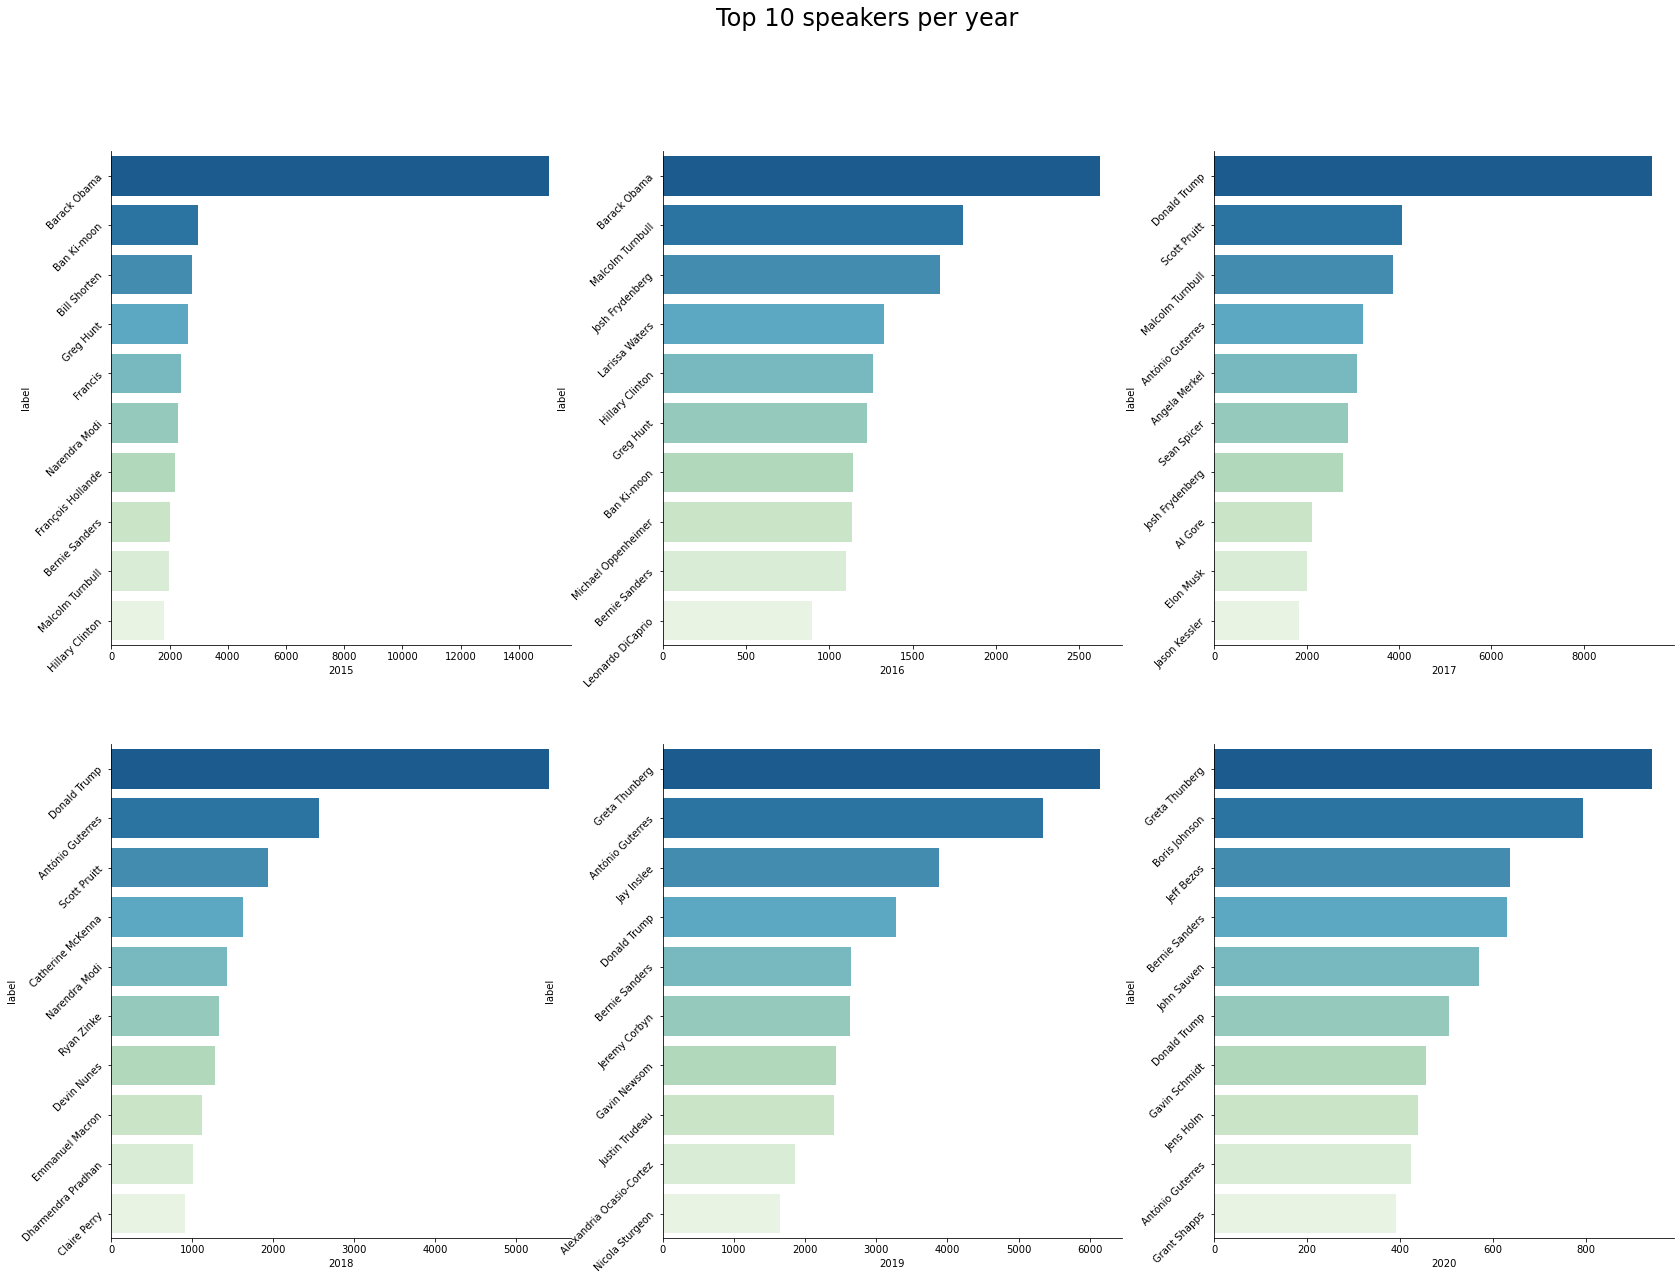

In [43]:
fig, axes = plt.subplots(2,3, figsize=(28,20)) #Creating the figure with the desired number of subplots.
fig.suptitle ('Top 10 speakers per year', 
              fontsize= 24)


palette = sns.color_palette("GnBu", n_colors=10)
palette.reverse()

#Creating a dictionary with plot parameters for every distribution: the subplot, if the element 
#is discrete or not, and the number of bins.  
fig_dic= {'2015': [axes[0,0]], 
          '2016': [axes[0,1]], 
          '2017':[axes[0,2]],
          '2018': [axes[1,0]], 
          '2019': [axes[1,1]], 
          '2020': [axes[1,2]],

         }
for key, value in fig_dic.items():
    sns.barplot(data=top_10[key], x=key, y='label',
             ax=value[0], palette=palette
                )
   
    value[0].tick_params(labelrotation=45, axis='y')
    sns.despine()

In [44]:
top_speakers=['Barack Obama', 'Donald Trump', 'Greta Thunberg']
template=[]
for speaker in top_speakers:
    template.append(climate.loc[(climate["label"].apply(lambda x : speaker == str(x)))])
df_top_speakers = pd.concat(template, ignore_index=False)

In [45]:
df_top_speakers.index=df_top_speakers.label

In [46]:
df_top_speakers

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,climate,2020,2019,2018,2017,2016,2015,Total
label,,,,,,,,,,,,,,,,,,
Barack Obama,1961,[United States of America],[male],"[African Americans, Multiracial American, Luo ...","[community organizer, statesperson, politician...",[Democratic Party],"[Bachelor of Arts, Juris Doctor]",Barack Obama,[2004 United States Senate election in Illinoi...,"[Protestantism, congregational church, Congreg...",1,174,1295,328,1598,2627,15034,21056
Donald Trump,1946,[United States of America],[male],[],"[television presenter, chief executive officer...","[Republican Party, Independence Party of Ameri...",[Bachelor of Science],Donald Trump,"[2016 United States presidential election, 202...",[Presbyterianism],1,504,3276,5403,9470,788,84,19525
Greta Thunberg,2003,[Sweden],[female],[],"[schoolchild, climate activist, author, activi...",[],[],Greta Thunberg,[],[],1,941,6148,107,0,0,0,7196


In [47]:
df_top_speakers = df_top_speakers[['2015','2016','2017','2018','2019','2020']].T

In [48]:
df_top_speakers.reset_index(inplace=True)
df_top_speakers

label,index,Barack Obama,Donald Trump,Greta Thunberg
0,2015,15034,84,0
1,2016,2627,788,0
2,2017,1598,9470,0
3,2018,328,5403,107
4,2019,1295,3276,6148
5,2020,174,504,941


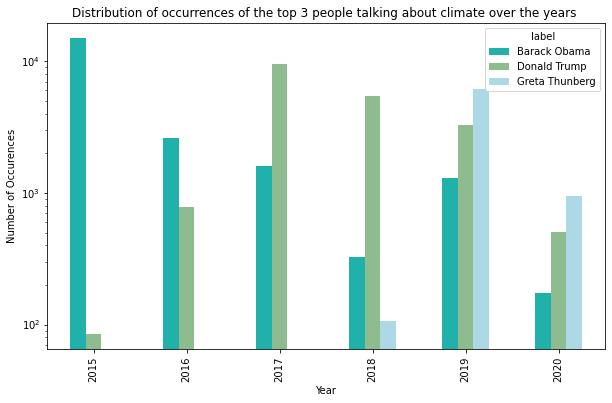

In [49]:
fig = df_top_speakers[['index','Barack Obama', 
                 'Donald Trump', 'Greta Thunberg']].plot(x='index', kind ='bar', color =['lightseagreen', 'darkseagreen', 'lightblue'], figsize=(10,6))


plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Number of Occurences')
plt.title('Distribution of occurrences of the top 3 people talking about climate over the years ')
plt.show()

### Top quotes

In [50]:
for key, value in top_10.items(): 
    print('Most mediated sentence from the top 10 speakers for year ' + key)
    for index, row in value.iterrows():
        year=literal_eval(key)
        print(row['label'] + ' : ' + dico_clean[year].loc[dico_clean[year][dico_clean[year]['qids'].apply(lambda x: str(x) == ("['" + str(index) + "']"))].numOccurrences.idxmax(), 'quotation'])
        

Most mediated sentence from the top 10 speakers for year 2015
Barack Obama : Climate change is not a problem for another generation,
Ban Ki-moon : The Paris Agreement on climate change is a monumental success for the planet and its people.
Bill Shorten : It's a real shame Malcolm Turnbull is following his party on climate change, not leading it,
Greg Hunt : We now need to find out how much blue carbon can be stored by these ecosystems and how this can contribute to emissions reductions,
Francis : Accepting the urgency, it seems clear to me, also, that climate change is a problem which can no longer be left to a future generation,
Narendra Modi : The prosperous still have a strong carbon footprint... [ while ] the countries at the bottom of the development ladder are seeking space to grow,
François Hollande : What is at stake with this climate conference is peace,
Bernie Sanders : climate change is directly related to the growth of terrorism,
Malcolm Turnbull : What we want from Paris..

# Sentiment Analysis

In [51]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [77]:
analyzer = SentimentIntensityAnalyzer()

In [78]:
dico_quotes = {}
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_quotes[date] = dico_clean[date]['quotation']

## Positive and negative distributions through the years

In [79]:
positive_sent = {}
negative_sent = {}


#iterate through the sentencs, get polarity scores, choose a value

for key, quotes in dico_quotes.items():
    ls_pos = []
    ls_neg = []
    for quote in quotes: 
        ls_pos.append(analyzer.polarity_scores(quote)['pos'])
        ls_neg.append(analyzer.polarity_scores(quote)['neg'])
    positive_sent[key] = ls_pos
    negative_sent[key] = ls_neg

In [80]:
def get_above_zero(my_list): #function to remove the feeling rates that equal exactly to zero as they were outliers
    np_arr = np.array(my_list)
    return np_arr[np_arr > 0]

In [81]:
def get_under_n(my_list,n): #function to remove the feeling rates that equal exactly to zero as they were outliers
    np_arr = np.array(my_list)
    return np_arr[np_arr < 0.45]

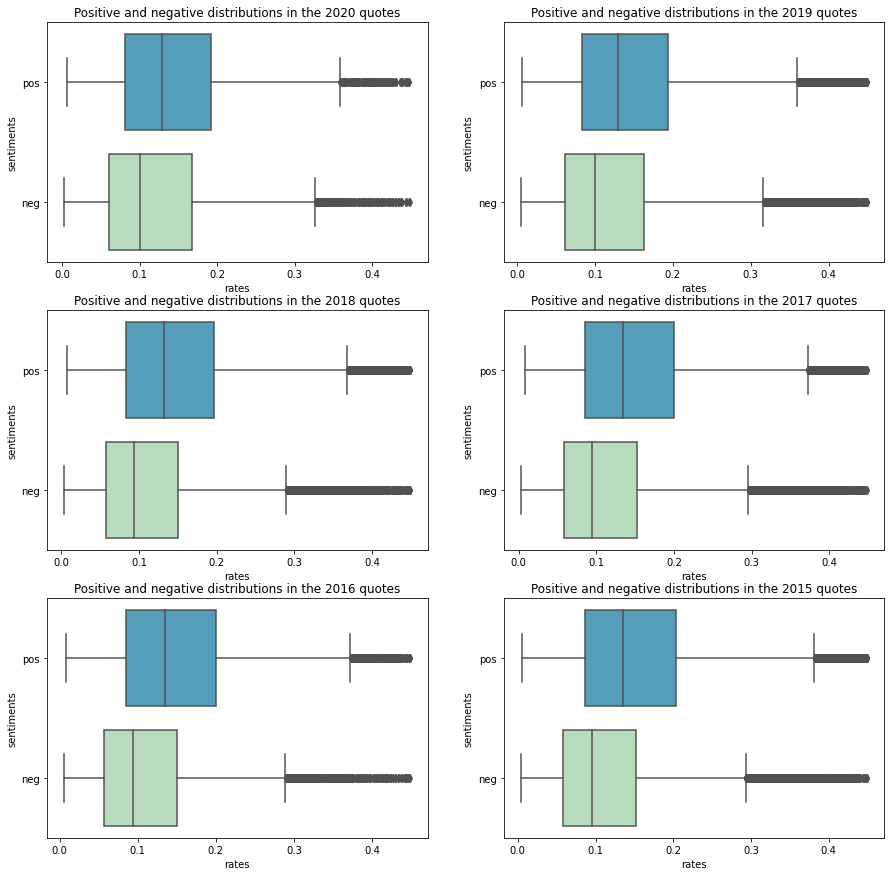

In [82]:
#plotting positive and negative sentiment rates of the quotes across time
fig, axes = plt.subplots(3,2, figsize=(15,15))

palette = sns.color_palette("GnBu", n_colors=2)
palette.reverse()

for idx, date in enumerate([2020, 2019, 2018, 2017, 2016, 2015]):

    ls_pos = get_above_zero(positive_sent[date])
    ls_neg = get_above_zero(negative_sent[date])
    #we decided to removed the values over 0.45 as we considered them as outliers 
    ls_pos = get_under_n(ls_pos,0.45)
    ls_neg = get_under_n(ls_neg,0.45)
    line, col = divmod(idx, 2)
    sns.boxplot(data = [ls_pos,ls_neg], orient = "h", ax = axes[line,col],showfliers=True, palette = palette).set(title = f'Positive and negative distributions in the {date} quotes', xlabel='rates', ylabel='sentiments')
    axes[line,col].set_yticklabels(['pos','neg'])

interpretation

## Democratic vs Republican

interpretation

In [105]:
def quotes_from_id(list): #this function keeps the lines from subdata that contain elements from the list 
    template=[] 
    for n in list: 
        template.append(quotes.loc[(quotes["qids"].apply(lambda x : n in str(x)))])
    return pd.concat(template, ignore_index=True)# return a dataframe with our data of interest

In [106]:
def quotes_sentiments(list): #this function returns two lists for positive and negative sentiments rates
    ls_pos = []
    ls_neg = []
    for n in list: 
        ls_pos.append(analyzer.polarity_scores(n)['pos'])
        ls_neg.append(analyzer.polarity_scores(n)['neg'])
        
    return ls_pos,ls_neg      

In [107]:
#we keep the lines of people that are in the parties of interest 
republican_climate = speakers[(speakers['climate']==1) & (speakers['party'].apply(lambda x : str(x) == "['Republican Party']"))]
democratic_climate = speakers[(speakers['climate']==1) & (speakers['party'].apply(lambda x : str(x) == "['Democratic Party']"))]

In [108]:
#df containing our quotes with respect of the id loaded above 
df_repu = quotes_from_id(republican_climate['id'])
df_demo = quotes_from_id(democratic_climate['id'])

In [109]:
#lists with our sentiment rates
ls_pos_rep, ls_neg_rep = quotes_sentiments(df_repu['quotation'])
ls_pos_dem, ls_neg_dem = quotes_sentiments(df_demo['quotation'])

[Text(0, 0, 'rep'), Text(0, 1, 'dem')]

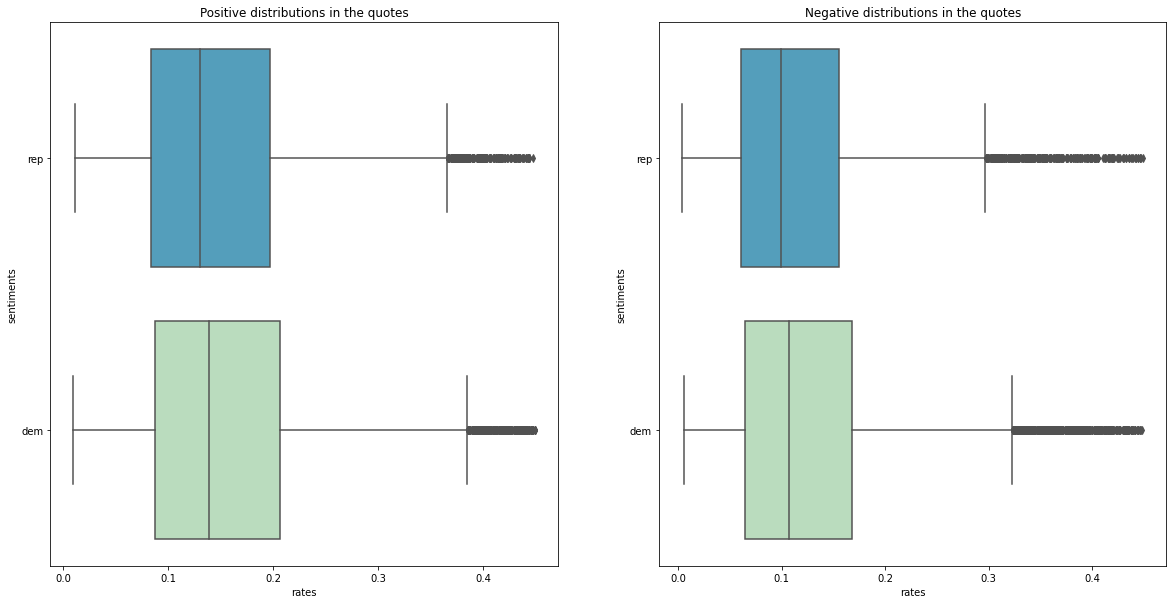

In [110]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

#we will remove outliers above 0.45

to_plot = [get_under_n(get_above_zero(ls_pos_rep),0.45),get_under_n(get_above_zero(ls_pos_dem),0.45)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[0], palette = palette).set(title = 'Positive distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[0].set_yticklabels(['rep','dem'])

to_plot = [get_under_n(get_above_zero(ls_neg_rep),0.45),get_under_n(get_above_zero(ls_neg_dem),0.45)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[1], palette = palette).set(title = 'Negative distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[1].set_yticklabels(['rep','dem'])

In [ ]:
ls_pos_ma, ls_neg_ma = quotes_sentiments(df_male['quotation'])
ls_pos_fe, ls_neg_fe = quotes_sentiments(df_female['quotation'])

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

#we will remove outliers above 0.45

to_plot = [get_under_n(get_above_zero(ls_pos_ma),0.45),get_under_n(get_above_zero(ls_neg_ma),0.45)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[0], palette = palette).set(title = 'Positive distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[0].set_yticklabels(['rep','dem'])

to_plot = [get_under_n(get_above_zero(ls_pos_fe),0.45),get_under_n(get_above_zero(ls_neg_fe),0.45)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[1], palette = palette).set(title = 'Negative distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[1].set_yticklabels(['rep','dem'])

# Classification of Speakers

In [113]:
#method to compute the confusion matrix 
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


#method to plot the matrix 
def plot_confusion_matrix(confusion_matrix):
    
    [[TP, FP],[FN, TN]] = confusion_matrix  #define the matrix
    
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]]) #label the boxes of the confusion matrix
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])  
    
    return sns.heatmap(df_cm, cmap='GnBu', annot=label, annot_kws={"size": 16}, cbar=False, fmt='') #plot heatmap


#compute the score 
def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    #calculate the precision  (what fraction of positive predictions is true)
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    #calculate the recall (what fraction of positive example are recognized as such)
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan
    
    #harmonic mean of the recall and precision

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [114]:
def accuracy (matrix_confusion) : 
  
 #recover the different performance of the classifier 
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(matrix_confusion)
    
 #print them 

    print("The accuracy of this model is {0:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))
    

In [121]:
def features_imp (train_f, params) :
    
    tmp = []
    for name, value in zip(train_f, params):
        tmp.append({"name": name, "value": value}) #concatenate value and names of the features

    features_coef = pd.DataFrame(tmp).sort_values("value")
    features_coef.head() # visualise first coefficient
    
    
    
    plt.subplots(figsize=(8,25))
    plt.title('Importance of Features')
    ax = sns.barplot(y= features_coef.name, x=features_coef.value, palette = palette)   #plot features_names and their relative importance into the model
 


## Data preparation

We recovered data from Handling_categorical_data and separate it to train and test set to performs our classification for climate.

In [116]:
data_original = pd.read_csv("data/one_hot.bz2", compression = 'bz2') #load the data one hot encoding

In [117]:
data = data_original.drop(['label'], axis=1).copy() #drop the label column
data.head(3)

,date_of_birth,climate,researcher,politician,association football player,actor,writer,painter,basketball player,journalist,...,male organism,cisgender female,two-spirit,agender,cisgender male,neutral sex,bigender,transfeminine,transmasculine,female organism
0,['+1732-02-22T00:00:00Z'],0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,['+1952-03-11T00:00:00Z'],0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,['+1868-08-23T00:00:00Z'],0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*preparation of our features*

In [118]:
X = data.drop(['climate'],axis=1)
y = data['climate']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split data into train and test set 

## Baseline model

Now we create a “baseline” for logistic classifier with stochastic gradient. This model uses all of the unmodified features and the default settings defined in the Scikit-learn logistic regression documentation. Basline model are simple model that are less likely to overfit and likely to be interpretable. it can helps us to get a better view on our data and show us a direction for the feature engineering. Moreover, comparaison between baseline and engineered model will helps us to conclude about our classification. 

The accuracy of this model is 0.983
For the positive case, the precision is 0.239, the recall is 0.001 and the F1 score is 0.002
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.991


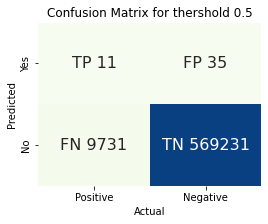

In [294]:
logistic=LogisticRegression(max_iter = 1000) #we indicate this parameters otherwise the model does not converge
logistic.fit(X_train, y_train)

prediction_proba=logistic.predict_proba(X_test) 
    
#construct the confusion matrix
confusion_matrix_05_baseline = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_baseline)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_baseline)

Based on the baselin model we can observe that our data is largely imbalanced : the classifier tend to alway predict 0 for climate and still get an amazing accarucy ! However, if we take a look at the F-score for positive case, we can observe that it is null... In fact, climate speakers are in minority in our data and so we need to modify our training set to get a satisfy classification. 

## Modification of the train set

*undersampling*

In [296]:
print('We have {} speakers talking about climate'.format(len(data[data['climate']==1])))
print('We have {} speakers that do not talking about climate'.format(len(data[data['climate']==0])))

We have 48722 speakers talking about climate
We have 2846314 speakers that do not talking about climate


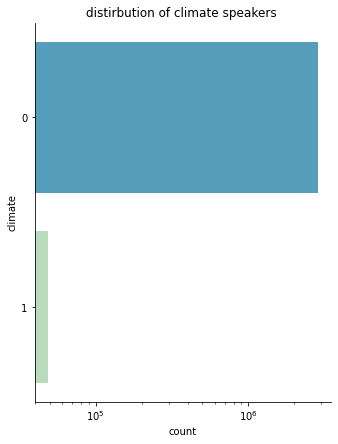

In [298]:
palette = sns.color_palette("GnBu", n_colors=2)
palette.reverse()



ax = sns.catplot(y="climate", data=data,
                kind="count", height=6, aspect=.8, palette=palette)
ax.set(xscale='log', title = 'distirbution of climate speakers ')
plt.show()

As we can see we have an  imbalanced datasets examples where climate speakers are in the minority class. This distribution cause bias in the training dataset and can influence our classification leading some to ignore the minority class entirely. We decided to manage this problem by randomly resampling the training dataset. The two main approaches are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling. In frame with the dimension of our dataset we decided to go with undersamplig.

In [302]:
undersample = RandomUnderSampler(sampling_strategy=0.5) #stategy = 0,5, majority class yill be the same amount as the minority class (1 to 1)

# fit and apply the transform into the train set
X_smote, y_smote = undersample.fit_resample(X_train, y_train)

In [303]:
print('Before undersampling we get {} non climate outcome, after undersampling we get {} climate outcome'.format(y_train.value_counts()[0], y_smote.value_counts()[0]))

Before undersampling we get 2277048 non climate outcome, after undersampling we get 77960 climate outcome


As we get a large number of features, dimensionality reduction could be an option, let's visualize the variance explained by each feature in order to select an interval containing the major components for the PCA 

*PCA on training set*

In [304]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
scaler=StandardScaler()
scaler.fit(X_smote)
train_scaled = pd.DataFrame(scaler.transform(X_smote), columns=X_smote.columns) 
test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) 

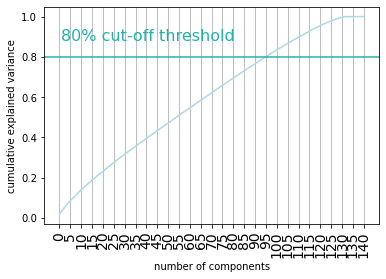

In [305]:
pca = PCA().fit(train_scaled)


plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'lightblue')



plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.8, color='lightseagreen', linestyle='-')
plt.text(0.5, 0.88, '80% cut-off threshold', color = 'lightseagreen', fontsize=16)
plt.xticks(np.arange(0, 142, step=5), rotation=90, fontsize=14)
plt.grid(axis='x')
plt.show()

In [306]:
#Creation of Dataframe containing the major components
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(100))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.017805,0.017805
1,0.032802,0.014997
2,0.047399,0.014597
3,0.060938,0.013540
4,0.073272,0.012334
...,...,...
95,0.801207,0.006874
96,0.808029,0.006822
97,0.814808,0.006779
98,0.821492,0.006684


Based on the graph we can see that each component does not have a great explained variance (<<0.02..), it seems that component beyteen 95 and 100 are required to explained at least 80% of the variance.

## Logistic Regression

Logistic regression measures the relationship between variable by estimating probabilities using a logistic function.
One thing we may want to do is rescale the features/inputs. Rescaling data brings values that may have extremely different ranges or units into alignment with one another. Bringing all the measurements into a similar scale helps the performance of the classifier (for a comparison try dropping the scaling and see how your performance decreases), and we can accomplish this with the StandardScaler from sklearn library. Another idea as already mention is to test for PCA.

*without  scaling and PCA*

In [307]:
#declaration of a pipe flow

pipe = Pipeline([('logistic',LogisticRegression())])
    

# pipe flow is : logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialization
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.7978979925767409
Best Params:  {'logistic__C': 1, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


*standarized without PCA* 

In [308]:
#declaration of a pipe flow

pipe = Pipeline([('std_slc', StandardScaler()),  
                 ('logistic',LogisticRegression()), ]
                 )
    
    
# pipe flow is :
#  Scaling the data -> Logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.8164649087256072
Best Params:  {'logistic__C': 1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Best Params:  {'logistic__C': 1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


*With PCA*

In [309]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('pca', PCA()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# PCA(Dimension reduction test for 95 or 100) -> Scaling the data -> logistic regression


#different parameters for hypertunning
n_components=[95, 100]
penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001, 0.1, 1, 10, 100]


# make lists of different parameters to check
param_grid = dict(pca__n_components=n_components, logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv =5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Score:  0.8062879498267914
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'pca__n_components': 100}


We can see that the second model returns the best accuracy: let's use it for our classification. 

## *Let's see the result !*

The accuracy of this model is 0.861
For the positive case, the precision is 0.071, the recall is 0.606 and the F1 score is 0.128
For the negative case, the precision is 0.992, the recall is 0.865 and the F1 score is 0.924


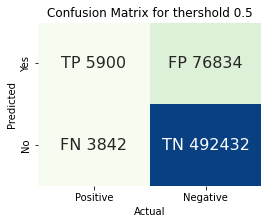

In [310]:
logistic=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=100)
logistic.fit(train_scaled, y_smote)

prediction_proba=logistic.predict_proba(test_scaled) 
    
#construct the confusion matrix
confusion_matrix_05_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_model)
    

#### 2.2 - Remove features vs not 

In [ ]:
features_imp (X_smote.columns, logistic.coef_[0])

In [312]:
sub_features_train=train_scaled.iloc[:,np.where(logistic.coef_[0]>0.015)[0]]
sub_features_test =test_scaled.iloc[:,np.where(logistic.coef_[0]>0.015)[0]]

The accuracy of this model is 0.861
For the positive case, the precision is 0.071, the recall is 0.601 and the F1 score is 0.127
For the negative case, the precision is 0.992, the recall is 0.866 and the F1 score is 0.925


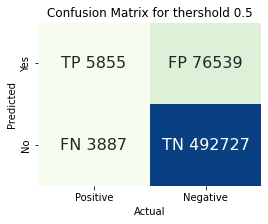

In [313]:
logistic_bis=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=1000)
logistic_bis.fit(sub_features_train, y_smote)

prediction_proba=logistic_bis.predict_proba(sub_features_test) 
    
#construct the confusion matrix
confusion_matrix_05_sub_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_sub_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_sub_model)

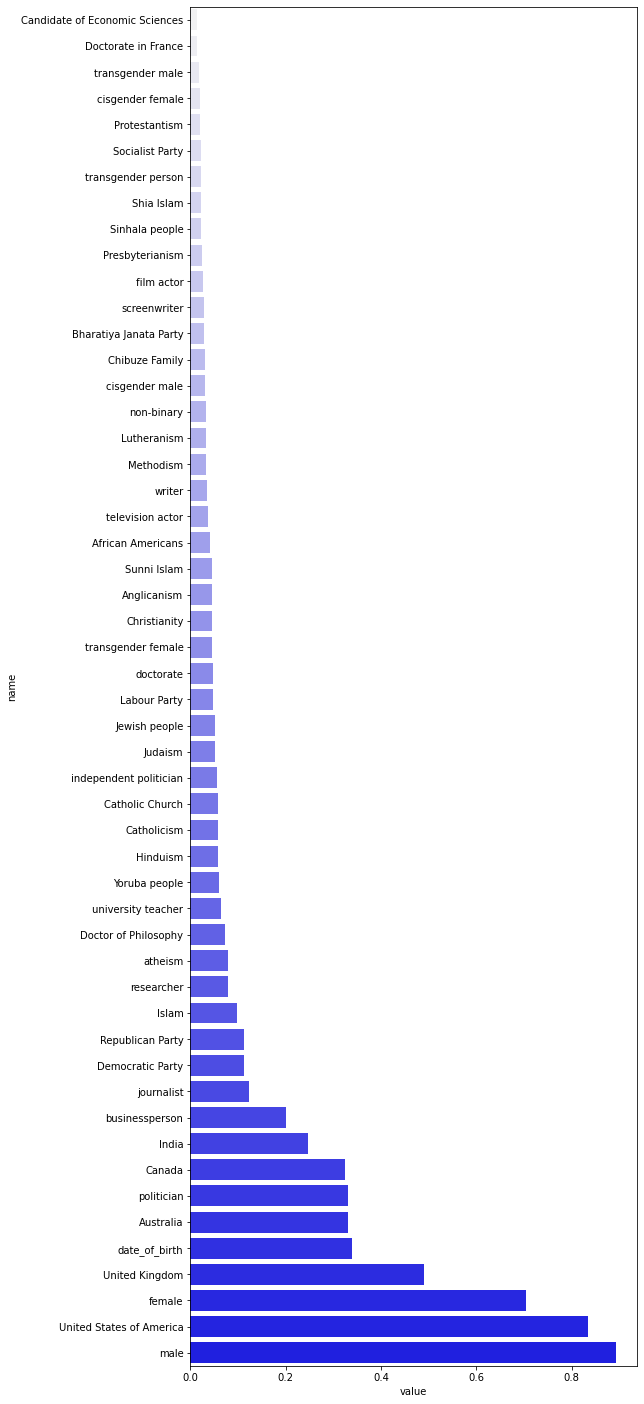

In [314]:
features_imp (sub_features_train.columns, logistic_bis.coef_[0])

#### 2.2 - classification per caracheristic 

In [315]:
occupation_train = X_smote.iloc[:, 1:21]
occupation_test = X_test.iloc[:, 1:21]
gender_train = X_smote.iloc[:, 121:141]
gender_test = X_test.iloc[:, 121:141]
nationality_train =X_smote.iloc[:, 61:81]
nationality_test  = X_test.iloc[:, 61:81]
academic_degree_train =X_smote.iloc[:, 101:121]
academic_degree_test  = X_test.iloc[:, 101:121]

In [316]:
dico={'occupation' : [occupation_train, occupation_test], 'gender' : [gender_train,gender_test],  
      'nationality ':[nationality_train, nationality_test], 'academic_degree' : [academic_degree_train, academic_degree_test] }

In [317]:
#declaration of a pipe flow
pipe = Pipeline([('logistic',LogisticRegression())])
    
    
# pipe flow is :
#  Scaling the data -> SDGClassifier


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data[0], y_smote)  
    print(f'Best Score for non standarized {name} is: ', grid_result.best_score_) 
    print(f'Best Params for non standarized {name} is : ', grid_result.best_params_) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized occupation is:  0.6283053279022988
Best Params for non standarized occupation is :  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized gender is:  0.5401612774676783
Best Params for non standarized gender is :  {'logistic__C': 100, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized nationality  is:  0.5151252345929462
Best Params for non standarized nationality  is :  {'logistic__C': 1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized academic_degree is:  0.5058299399239352
Best Params for non standarized

In [318]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# Scaling the data -> Logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs', 'sag']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data[0], y_smote)  
    print(f'Best Score for  standarized {name} is : ', grid_result.best_score_) 
    print(f'Best Params for  standarized {name} is: ', grid_result.best_params_) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized occupation is :  0.6282983286149294
Best Params for  standarized occupation is:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized gender is :  0.5401613432813818
Best Params for  standarized gender is:  {'logistic__C': 0.001, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized nationality  is :  0.515124772251679
Best Params for  standarized nationality  is:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized academic_degree is :  0.5058297260293989
Best Params for  standarized academic_degree 

## *Let's see the result !*

The accuracy of this model is 0.877
For the positive case, the precision is 0.042, the recall is 0.286 and the F1 score is 0.073
For the negative case, the precision is 0.986, the recall is 0.887 and the F1 score is 0.934
The accuracy of this model is 0.983
For the positive case, the precision is 0.055, the recall is 0.002 and the F1 score is 0.003
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.991
The accuracy of this model is 0.978
For the positive case, the precision is 0.077, the recall is 0.026 and the F1 score is 0.039
For the negative case, the precision is 0.984, the recall is 0.995 and the F1 score is 0.989
The accuracy of this model is 0.982
For the positive case, the precision is 0.071, the recall is 0.006 and the F1 score is 0.011
For the negative case, the precision is 0.983, the recall is 0.999 and the F1 score is 0.991


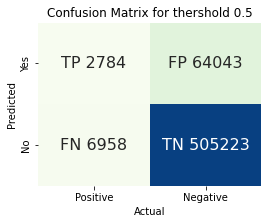

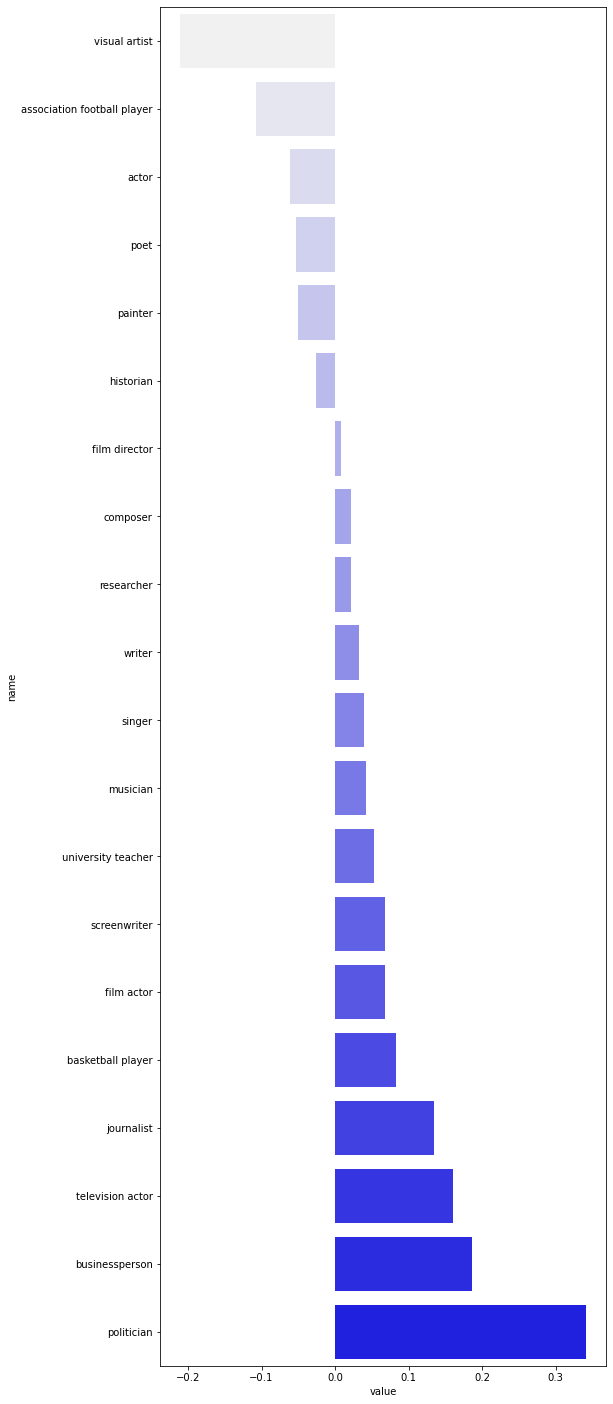

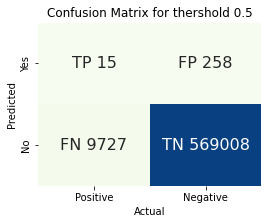

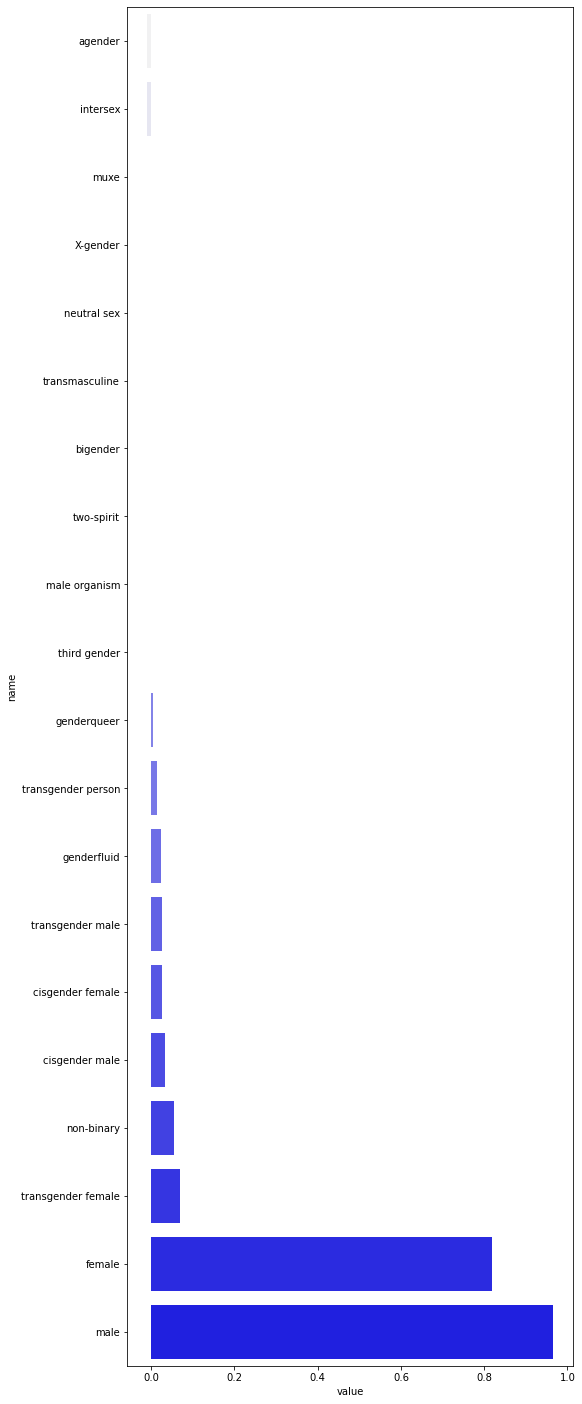

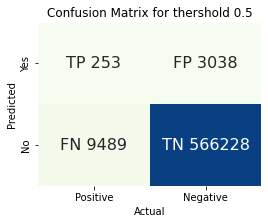

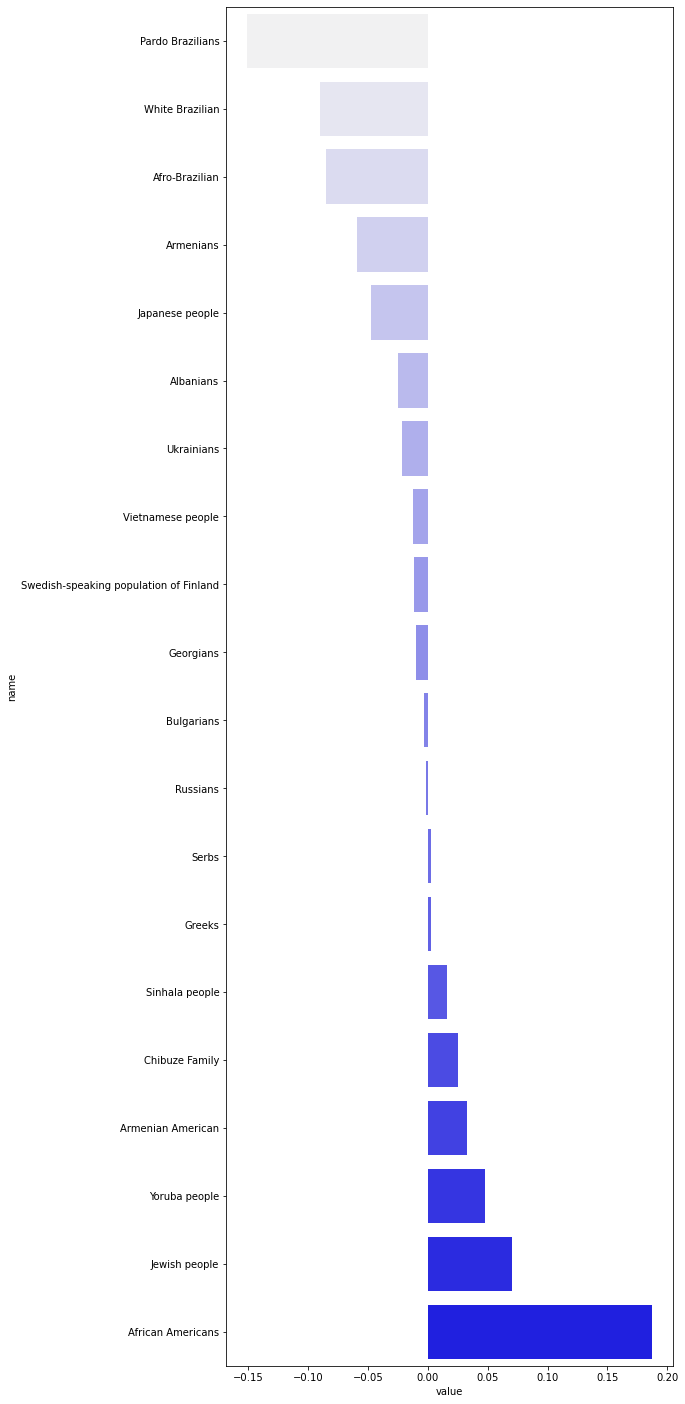

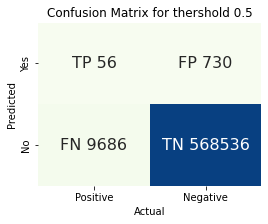

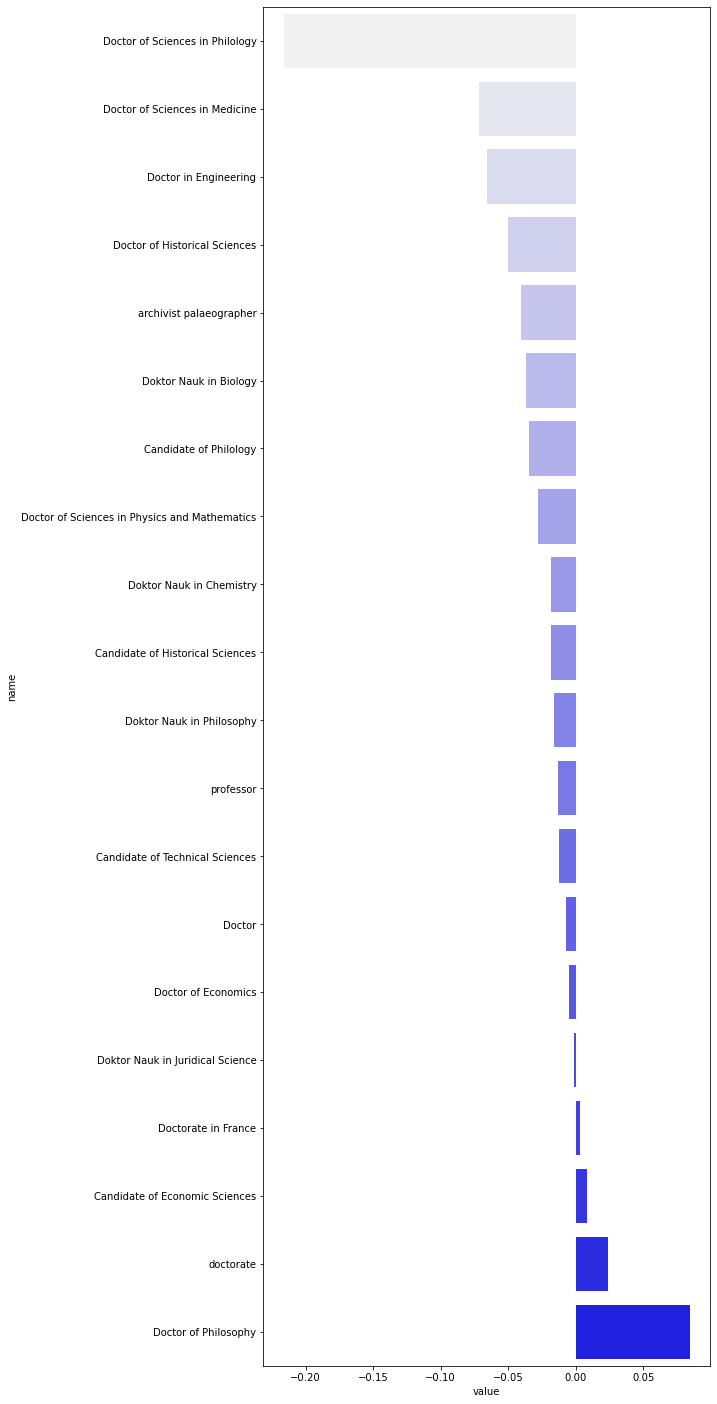

In [319]:
C=[0.01, 0.01, 1, 100]

i=0
for name, data in dico.items() :
    
    scaler=StandardScaler()
    scaler.fit(data[0])
    
  
    train_scaled_ = pd.DataFrame(scaler.transform(data[0]), columns=data[0].columns) 
    test_scaled_ = pd.DataFrame(scaler.transform(data[1]), columns=data[1].columns) 
    
   
    
    logistic_categories=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=C[i], max_iter=10000)
    logistic_categories.fit(train_scaled_, y_smote)
    prediction_proba_categories=logistic_categories.predict_proba(test_scaled_) 
    
    
    #construct the confusion matrix
    confusion_matrix_05_sub_cat = compute_confusion_matrix(y_test, prediction_proba_categories, 0.5)
    plt.figure(figsize = (4,3))   
    ax = plot_confusion_matrix(confusion_matrix_05_sub_cat)
    #setting axis
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ax.set(title = 'Confusion Matrix for thershold 0.5')
    #get the accuracy of the model
    print(f'for {name} categories we obtained :')
    accuracy (confusion_matrix_05_sub_cat)
    
    features_imp (train_scaled_.columns, logistic_categories.coef_[0])
    i+=1
    